# Amazon Alexa Review - Sentiment Analysis

Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [4]:
%pip install seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle

import re

Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
%pip install xgboost

Note: you may need to restart the kernel to use updated packages.


### Exploratory Data Analysis

In [6]:
%pip install kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prishasawhney/product-reviews")

print("Path to dataset files:", path)

Note: you may need to restart the kernel to use updated packages.


d:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\myenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: C:\Users\ASUS\.cache\kagglehub\datasets\prishasawhney\product-reviews\versions\1


In [8]:
#Load the data

data = pd.read_csv(r"C:\Users\ASUS\Downloads\reviews.csv")

print(f"Dataset shape : {data.shape}")
data.head()

Dataset shape : (386, 2)


,Review,Sentiment
0,This product exceeded my expectations! It's hi...,Positive
1,"The product was decent. It worked fine, but it...",Neutral
2,I had a terrible experience with this company....,Negative
3,It's an okay product. Nothing to write home ab...,Neutral
4,Disappointed with the product. It didn't meet ...,Negative


In [9]:
#Column names

print(f"Feature names : {data.columns.values}")

Feature names : ['Review' 'Sentiment']


In [10]:
#Check for null values

data.isnull().sum()

Review       0
Sentiment    0
dtype: int64

There is one record with no 'verified_reviews' (null value)

In [11]:
#Getting the record where 'verified_reviews' is null 

data[data['Review'].isna() == True]

,Review,Sentiment


In [12]:
#We will drop the null record

data.dropna(inplace=True)

In [13]:
print(f"Dataset shape after dropping null values : {data.shape}")

Dataset shape after dropping null values : (386, 2)


In [14]:
#Creating a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['Review'].apply(len)

In [15]:
data.head()

,Review,Sentiment,length
0,This product exceeded my expectations! It's hi...,Positive,89
1,"The product was decent. It worked fine, but it...",Neutral,71
2,I had a terrible experience with this company....,Negative,91
3,It's an okay product. Nothing to write home ab...,Neutral,50
4,Disappointed with the product. It didn't meet ...,Negative,62


The 'length' column is new generated column - stores the length of 'verified_reviews' for that record. Let's check for some sample records

In [16]:
#Randomly checking for 10th record

print(f"'verified_reviews' column value: {data.iloc[10]['Review']}") #Original value
print(f"Length of review : {len(data.iloc[10]['Review'])}") #Length of review using len()
print(f"'length' column value : {data.iloc[10]['length']}") #Value of the column 'length'

'verified_reviews' column value: Absolutely horrendous service. Never again.
Length of review : 43
'length' column value : 43


We can see that the length of review is the same as the value in the length column for that record

Datatypes of the features

In [17]:
data.dtypes

Review       object
Sentiment    object
length        int64
dtype: object

* rating, feedback and length are integer values <br>
* date, variation and verified_reviews are string values

### Analyzing 'rating' column

This column refers to the rating of the variation given by the user

In [18]:
len(data)

386

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [19]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', data.iloc[i]['Review'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

Using Count Vectorizer to create bag of words

In [21]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
# Map sentiment labels to numerical values
y = data['Sentiment'].map({'Positive': 1, 'Negative': 0, 'Neutral': 2})


In [22]:
from joblib import dump, load
#Saving the Count Vectorizer
dump(cv, r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\countVectorizer.joblib")


['D:\\ML\\Sentiment-Analysis-main\\Sentiment-Analysis-main\\Models\\countVectorizer.joblib']

Checking the shape of X and y

In [23]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (386, 141)
y shape: (386,)


Splitting data into train and test set with 30% data with testing.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")

X train: (270, 141)
y train: (270,)
X test: (116, 141)
y test: (116,)


In [25]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

X train max value: 2
X test max value: 2


We'll scale X_train and X_test so that all values are between 0 and 1.

In [26]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

# Check for NaN or infinite values in X_train_scl
print("NaN values in X_train_scl:", np.isnan(X_train_scl).sum())
print("Infinite values in X_train_scl:", np.isinf(X_train_scl).sum())

# Check for NaN or infinite values in y_train
print("NaN values in y_train:", np.isnan(y_train).sum())
print("Infinite values in y_train:", np.isinf(y_train).sum())

NaN values in X_train_scl: 0
Infinite values in X_train_scl: 0
NaN values in y_train: 0
Infinite values in y_train: 0


In [27]:
dump(scaler, r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\scaler.joblib")


['D:\\ML\\Sentiment-Analysis-main\\Sentiment-Analysis-main\\Models\\scaler.joblib']

#### Random Forest

In [28]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

RandomForestClassifier()

In [29]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9913793103448276


In [30]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [31]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

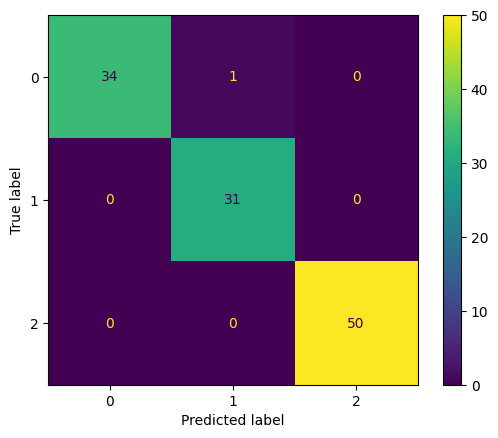

In [32]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [33]:
dump(model_rf, r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\Model_rf.joblib")


['D:\\ML\\Sentiment-Analysis-main\\Sentiment-Analysis-main\\Models\\Model_rf.joblib']

K fold cross-validation

In [34]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Accuracy : 0.9629629629629631
Standard Variance : 0.028688765527462346


Applying grid search to get the optimal parameters on random forest

In [35]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [36]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

C:\Users\ASUS\AppData\Local\Temp\ipykernel_4300\1207927100.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  grid_search.fit(X_train_scl, y_train.ravel())
d:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\myenv\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [80, 100],
                         'min_samples_split': [8, 12],
                         'n_estimators': [100, 300]},
             return_train_score=True)

In [37]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

Best Parameter Combination : {'bootstrap': True, 'max_depth': 100, 'min_samples_split': 8, 'n_estimators': 300}


In [38]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

Cross validation mean accuracy on train set : 99.62962962962962
Cross validation mean accuracy on test set : 93.05555555555556
Accuracy score for test set : 0.9913793103448276


#### XgBoost

In [39]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [40]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9482758620689655


In [41]:
y_preds = model_xgb.predict(X_test)

In [42]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[32  2  1]
 [ 2 29  0]
 [ 0  1 49]]


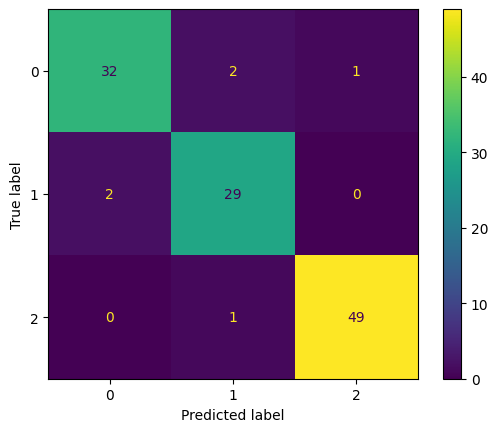

In [43]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

In [44]:
dump(model_xgb, r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\Model_xgb.joblib")


['D:\\ML\\Sentiment-Analysis-main\\Sentiment-Analysis-main\\Models\\Model_xgb.joblib']

#### Decision Tree Classifier

In [45]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

DecisionTreeClassifier()

In [46]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

Training Accuracy : 1.0
Testing Accuracy : 0.9741379310344828


In [47]:
y_preds = model_dt.predict(X_test)

In [48]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

[[33  2  0]
 [ 0 31  0]
 [ 0  1 49]]


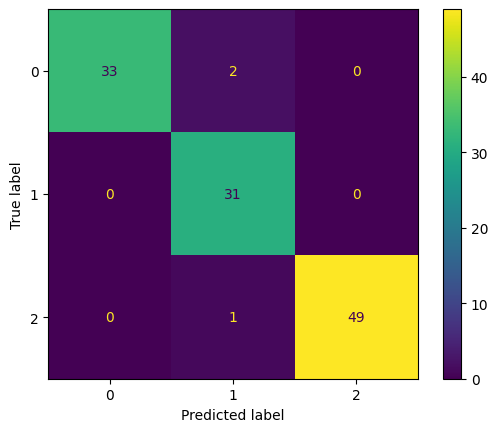

In [49]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

In [50]:
dump(model_dt, r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\Model_dt.joblib")


['D:\\ML\\Sentiment-Analysis-main\\Sentiment-Analysis-main\\Models\\Model_dt.joblib']

In [73]:
from joblib import load

# Loading models and scalers using joblib
predictor = load(r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\Model_rf.joblib")
scaler = load(r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\scaler.joblib")
cv = load(r"D:\ML\Sentiment-Analysis-main\Sentiment-Analysis-main\Models\countVectorizer.joblib")


In [76]:
def single_prediction(predictor, scaler, cv, text_input):
    corpus = []
    stemmer = PorterStemmer()
    review = re.sub("[^a-zA-Z]", " ", text_input)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = " ".join(review)
    corpus.append(review)
    X_prediction = cv.transform(corpus).toarray()
    X_prediction_scl = scaler.transform(X_prediction)
    y_predictions = predictor.predict_proba(X_prediction_scl)
    y_predictions = y_predictions.argmax(axis=1)[0]

    if y_predictions == 1:
        return "Postive"
    elif y_predictions == 0:
        return "Negative"
    else:
        return "Neutral"
text_input = "This earbuds are the worst, and 0 stars from me!"
predicted_sentiment = single_prediction(predictor, scaler, cv, text_input)
print(predicted_sentiment)

Negative
